In [1]:
from __future__ import print_function
import os.path
import dalmatian as dm
import pandas as pd
import gzip
import sys
sys.path.insert(0, '..')
from src.CCLE_postp_function import *

from JKBio import Datanalytics as da 
from JKBio import TerraFunction as terra
from JKBio.Helper import * 
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
from IPython.display import Image,display
from taigapy import TaigaClient
tc = TaigaClient()
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from bokeh.plotting import *
from bokeh.models import HoverTool
output_notebook()
from collections import OrderedDict
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret.json', '~/.storage.json')
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

you need to have installed JKBio in the same folder as ccle_processing


Loading BokehJS ...

In [2]:
samplesetname="20Q2"
prevname="20Q1"
prevprevname = "19Q4"
prevprevversion='21'
virtual_public='public-20q2-075d'
virtual_dmc='dmc-20q2-2db6'
virtual_internal='internal-20q2-7f46'

workspace2="broad-firecloud-ccle/CCLE_DepMap_RNAseq"
workspace4="broad-genomics-delivery/Cancer_Cell_Line_Factory_CCLF_RNAseq"
workspace5="nci-mimoun-bi-org/CCLF_RNA_2_0"

workspace3="broad-genomics-delivery/CCLE_DepMap_RNAseq"
workspace1="broad-genomics-delivery/Getz_IBM_CellLines_RNASeqData"

workspace6="terra-broad-cancer-prod/CCLE_DepMap_RNAseq"
workspace7="terra-broad-cancer-prod/Getz_IBM_CellLines_RNASeqData"

refworkspace="broad-firecloud-ccle/DepMap_hg38_RNAseq"
source1="ibm"
source2="ccle"
source3="ccle"
source4="cclf"
source5="cclf"
source6="ccle"
source7="ibm"
release = samplesetname

refsheet_url = "https://docs.google.com/spreadsheets/d/1XkZypRuOEXzNLxVk9EOHeWRE98Z8_DBvL4PovyM01FE"
privacy_release_url = "https://docs.google.com/spreadsheets/d/115TUgA1t_mD32SnWAGpW9OKmJ2W5WYAOs3SuSdedpX4"

In [3]:
%%R
genome_version <- 'hg38'
release <- '20Q2'
hg38_cyto_band_reference <- '../JKBio/data/hg38_cytoband.gz'

# Generate sample set from new samples

In [4]:
extract_to_change = {'from_arxspan_id': 'participant',
}

In [5]:
wm1 = dm.WorkspaceManager(workspace1)
#wm2 = dm.WorkspaceManager(workspace2)
wm3 = dm.WorkspaceManager(workspace3)
#wm4 = dm.WorkspaceManager(workspace4)
#wm5 = dm.WorkspaceManager(workspace5)
wm6 = dm.WorkspaceManager(workspace6)
wm7 = dm.WorkspaceManager(workspace7)
refwm = dm.WorkspaceManager(refworkspace)

In [6]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame()

In [ ]:
# we will be missing "primary disease","sm_id", "cellosaurus_id", "gender, "age", "primary_site", "primary_disease", "subtype", "subsubtype", "origin", "comments"
#when SMid: match==
samples, pairs, noarxspan = GetNewCellLinesFromWorkspaces(refworkspace, stype='rna', refurl=refsheet_url, wmfroms = [workspace1, workspace3, workspace6, workspace7], sources=[source1, source3,source6, source7], match=['ACH-','CDS-'], participantslicepos=10, accept_unknowntypes=True, extract=extract_to_change, recomputedate=True)

In [ ]:
samples

In [ ]:
# I am trying to remove duplicates from samples without arxspan ids to then look more into them and see if I have to get data for them or if I should just throw them out
toremov=set()
for k, val in noarxspan.iterrows():
    withsamesize = noarxspan[noarxspan["sample_id"] == val["sample_id"]]
    if len(withsamesize) > 1:
        for l, v in withsamesize.iloc[1:].iterrows():
            toremov.add(l)

In [ ]:
for i in toremov:
    noarxspan = noarxspan.drop(i)

In [ ]:
len(noarxspan)

In [ ]:
noarxspan.sample_id = [i.split('NA_O')[0] for i in noarxspan.sample_id]

In [ ]:
noarxspan['ccle_name'] = [''.join(i.split('_')[1:-1]).split('v')[0] for i in noarxspan.sample_id]
noarxspan['readgroup'] = [i.split('_')[0] for i in noarxspan.sample_id]

In [ ]:
noarxspan['ccle_name'].tolist()

In [ ]:
for i, v in noarxspan.iterrows():
    if not gcp.exists(v['cram_or_bam_path']):
        print(v.ccle_name)
        noarxspan = noarxspan.drop(i)

In [ ]:
toupdate = {"gender":[],
"primary_disease":[],
"sm_id":[],
"cellosaurus_id":[],
"age":[],
"primary_site":[],
"subtype":[],
"subsubtype":[],
"origin":[],
"comments":[],
"patient_id":[]}

In [ ]:
refwm.get_bucket_id()

In [ ]:
# If I have a previous samples I can update unknown data directly
index=[]
notfound=[]
for k, val in samples.iterrows():
    dat = ccle_refsamples[ccle_refsamples['arxspan_id']==val['arxspan_id']]
    if len(dat)>0:
        index.append(k)
        for k, v in toupdate.items():
            toupdate[k].append(dat[k].tolist()[0])
    else:
        notfound.append(k)

In [ ]:
len(toupdate['patient_id'])

In [ ]:
# doing so..
for k, v in toupdate.items():
    samples.loc[index,k] =v

In [ ]:
len(samples.loc[notfound].patient_id)

In [ ]:
# for these samples I will need to check and manually add the data in the list 
samples.loc[notfound]

In [ ]:
# found same patient
a = ["ACH-000635","ACH-000717", "ACH-000864", "ACH-001042", "ACH-001547"]
b = ["ACH-002291","ACH-001672"]

In [ ]:
ccle_refsamples[ccle_refsamples.arxspan_id.isin(a)].patient_id

In [ ]:
# if we found we had cell lines from different patients
ccle_refsamples.loc[ccle_refsamples[ccle_refsamples.arxspan_id.isin(a)].index,"patient_id"]="PT-B15oIzKN"

In [ ]:
# duplicate ach-id
dup = {"ACH-001620": "ACH-001605",
"ACH-001621": "ACH-001606"}

In [ ]:
ccle_refsamples[ccle_refsamples.arxspan_id=="ACH-001605"]

In [ ]:
samples.loc["CDS-R2h6fu","arxspan_id"]="ACH-001620"

In [ ]:
samples = changeCellLineNameInNewSet(new = samples, ref=ccle_refsamples, datatype="rna", dupdict=dup)

In [ ]:
samples

In [ ]:
notfound.remove("CDS-R2h6fu")

In [ ]:
#rename ccle_name TODO: ask becky what to do
rename = {"PEDS117": "CCLFPEDS0009T"}

In [ ]:
len(notfound)

## getting the addtional data and writing it here in the right order 'as shown above'
- use the stripped_cell_line_name to find the samples on https://docs.google.com/spreadsheets/d/1uqCOos-T9EMQU7y2ZUw4Nm84opU5fIT1y7jet1vnScE/edit#gid=356471436. 
- Make sure that we don't have duplicate cell lines in there. Otherwise, use the duplicate renaming function
- copy Primary Site, Primary Disease, Subtype, Comments, Disease Sub-subtype, if they exist. (sometimes subtype and subsubtype are the same.. don't use subsubtype then.
- look for the cell line in cellosaurus, you might need to use one of the aliases given in master depmap pv..
- copy  cellosaurus_id gender age info or write 'U' if they don't exist. 'can be a number or {Embryonic, Children, Adult, Fetus, U} 
- check that it does not say this cell line is not a duplicate from another cell line
- check that if it says this cell line is derived/children/father/samepatient from other cell lines, and that if we have any of the other cell lines, that the patient id is changed to be the same one for all (be sure that you are updating everywhere these patient ids are used)

In [ ]:
# TODO: sample info file has different age annotations
toupdate = {"sm_id":[""]*30,
            
"cellosaurus_id":['CVCL_H248',"","CVCL_S505","CVCL_2277","CVCL_1966","CVCL_M147","CVCL_2024","CVCL_A344","CVCL_8354","CVCL_S506","CVCL_M258","CVCL_2581","CVCL_2604","CVCL_4449","CVCL_2610","CVCL_M266","CVCL_4D12","CVCL_3118","","CVCL_T041","CVCL_1852","CVCL_2777","CVCL_B371", "CVCL_3220","CVCL_1854","CVCL_2223","CVCL_2226","CVCL_1903","CVCL_3423","CVCL_1898"],
"gender":['Female',"Male","Male","Male","Male","Male","Female","Male","Female","Male","Male","Male","Male","Female","Male","U","Female","Male","U",'Female',"Male","Male","Male","Female","Male","Female","Female","Male","Female","Male"],
            
"age":[2,'U',"Embryo","Embryo",7,12,49,"Embryo",52,3,56,57,"U","U","U",18,49,71,"U",55,11,22,10,22,57,61,69,37,"U",42],
            
"primary_site":["haematopoietic_and_lymphoid_tissue","skin","Embryonal","Embryonal","haematopoietic_and_lymphoid_tissue","central_nervous_system","pleural_effusion","Embryonal","ascites","central_nervous_system","biliary_tract","pleural_effusion","lymph_node","lymph_node","lymph_node","biliary_tract","uvea","biliary_tract","bone","pleural_effusion","haematopoietic_and_lymphoid_tissue","lung","haematopoietic_and_lymphoid_tissue","Thymus","ascites","upper_aerodigestive_tract","upper_aerodigestive_tract","haematopoietic_and_lymphoid_tissue","breast","haematopoietic_and_lymphoid_tissue"],
            
"primary_disease":['Leukemia',"Skin Cancer","Embryonal Cancer","Embryonal Cancer","Lymphoma","Brain Cancer","Lymphoma","Teratoma","Ovarian Cancer","Brain Cancer","Bile Duct Cancer","Lung Cancer","Skin Cancer","Skin Cancer","Skin Cancer","Bile Duct Cancer","Eye Cancer","Bile Duct Cancer","Bone Cancer","Breast Cancer","Leukemia","Embryonal Cancer","Lymphoma","Thymic Cancer","Lymphoma","Head and Neck Cancer","Head and Neck Cancer","Lymphoma","Breast Cancer","Lymphoma"],
            
"subtype":['AML',"Melanoma","Carcinoma","Carcinoma","B-cell, Non-Hodgkins, Burkitts","Glioblastoma","B-cell, Non-Hodgkins, Burkitts","Testicular","Adenocarcinoma, clear cell","Medulloblastoma","Cholangiocarcinoma","Mesothelioma","Melanoma","Melanoma","Melanoma","Engineered","Uveal Melanoma","Cholangiocarcinoma","Ewings Sarcoma","Breast Ductal Carcinoma","Acute Lymphoblastic Leukemia (ALL), B-cell","Carcinoma","B-cell, Non-Hodgkins, Burkitts","Carcinoma","B-cell","Squamous Cell Carcinoma","Squamous Cell Carcinoma","B-cell","Carcinoma","B-cell"],
            
"subsubtype":["",'acral',"","","b_cell_burkitt","","","","","","","","","","","engineered_bile_duct","","intrahepatic","","","b_cells","","b_cell_burkitt","anaplastic","","","","","ERneg_HER2pos",""],
            
"origin":['']*30,
            
"comments":["Gifted to Fred Hutchinson Cancer Center by Dr. Jeff Taub at Wayne State University; Received from Academic lab (FHCRC and Taub, Wayne State University)","M1610113 (p9); Mutation: NRASG12R; biopsy site - right dorsal heel; Received from Academic lab (Hayward, QIMRB)","cytoreductive thoracotomy specimen of a man with primary retroperitoneal embryonal carcinoma","retro-peritoneal metastasis of a non seminomatous germ cell carcinoma","","Received from Academic lab (Hong, Broad)","","malignant testicular teratoma (intermediate grade)","ovarian clear cell adenocarcinoma","","Human poorly differentiated cholangiocarcinoma cell line established from biliary tract.","","taken from metastatic site: lymph node","taken from metastatic site: lymph node","taken from metastatic site: lymph node","Received from Academic lab (Bardeesy, MGH)/DSMZ","display GNAQ or GNA11 activating mutations","Received from Academic lab (Bardeesy, MGH)/DSMZ","(PCR) EWS/FLI","breast cancer, Infiltrating ductal carcinoma","ST & GR-ST are subclones of Tanoue (JCRB). GR-ST are ST cells transformed with human G-CSF receptor cDNA. Responds to G-CSF.","malignant embryonal carcinoma derived from lung","Human lymphoid cell line derived from Burkitt's lymphoma. Tumorigenic in nude mouse (meta from ileocecal lymph node)","Thymic carcinoma cell line.","","","","","HER2Amp; basal",""],
            
"patient_id":["PT-IMn7eqLZ","PT-pUBtKkYR","PT-El9YBuz5","PT-P6Iueia9", "PT-2gssvols", "PT-NczSWWPv", "PT-RY8p3mdI", "PT-olH0fsQe", "PT-3CksfnKs", "PT-OrIcgwcE", "PT-W3uUJEi1", "PT-B15oIzKN", "PT-fo7MYTEA", "PT-ley1jk9c", "PT-3f6vZIv9", "PT-MdR8meiJ", "PT-z5KcZzaT", "PT-3wNFFmJl", "PT-gpiijlSj", "PT-bdAvWDQz", "PT-uDGwdjJW", "PT-L63btI6L", "PT-uXJgRBuh", "PT-GkdLfVhc", "PT-UGLaOKH7", "PT-hw8KmxDu", "PT-G3kJesC0", "PT-zFOjyoHz", "PT-A8FG8EcM", "PT-98h5OTqP"]}

In [ ]:
a  = pd.DataFrame(toupdate)
a['name'] = samples.loc[notfound,"stripped_cell_line_name"].tolist()
a

In [ ]:
# updating..
for k, v in toupdate.items():
    samples.loc[notfound,k] =v

In [ ]:
# uploading to our bucket (now a new function)
a = changeToBucket(samples,'gs://cclebams/rna/', values=['internal_bam_filepath','internal_bai_filepath'], catchdup=False)

In [ ]:
mkdir temp

In [ ]:
# saving and updating the spreadsheet with these
print("YOU NOW NEED TO UPDATE THE GOOGLE SHEET!")
pd.concat([ccle_refsamples,samples],sort=False).to_csv('temp/updated_ccle_samples.csv')

In [ ]:
samples['arxspan_id'].tolist()

In [ ]:
samples = samples.rename(columns={'patient_id':'participant_id'})

In [ ]:
#pairs.participant_id = samples.participant_id

In [ ]:
#pairs = pairs.rename(columns={'patient_id':'participant_id'}).set_index('pair_id')

In [ ]:
#uploading new samples
refwm = refwm.disable_hound()
#refwm.upload_samples(samples)
#refwm.upload_entities('pairs', pairs)
#creating a sample set
refwm.update_sample_set(sample_set_id=samplesetname, sample_ids=samples.index)

## Check that we have all the cell lines we expect for this release
This involves comparing to the list in the Google sheet "Cell Line Profiling Status."

In [ ]:
# this function may not work - it hasn't been tested
url = 'https://docs.google.com/spreadsheets/d/1qus-9TKzqzwUMNWp8S1QP4s4-3SsMo2vuQRZrNXf7ag'

compareToCuratedGS(url, sample = samples, samplesetname = samplesetname, colname = 'RNA New to internal')

# run the pipeline

We are using Dalmatian to send request to Terra, we are running a set of 6 functions To generate the expression/fusion dataset:

We use the GTEx pipeline ([https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md](https://github.com/broadinstitute/gtex-pipeline/blob/v9/TOPMed_RNAseq_pipeline.md)).

To generate the expression dataset, run the following tasks on all samples that you need, in this order:



*   samtofastq_v1-0_BETA_cfg 

    (broadinstitute_gtex/samtofastq_v1-0_BETA Snapshot ID: 5)

*   star_v1-0_BETA_cfg

(broadinstitute_gtex/star_v1-0_BETA Snapshot ID: 7)



*   rsem_v1-0_BETA_cfg 

    (broadinstitute_gtex/rsem_v1-0_BETA Snapshot ID: 4)

*   rsem_aggregate_results_v1-0_BETA_cfg (broadinstitute_gtex/rsem_aggregate_results_v1-0_BETA Snapshot ID: 3)

The outputs to be downloaded will be saved under the sample set that you ran. The outputs we use for the release are:



*   rsem_genes_expected_count
*   rsem_genes_tpm
*   rsem_transcripts_tpm

****Make sure that you delete the intermediate files. These files are quite large so cost a lot to store. To delete, you can either write a task that deletes them or use gsutil rm*****


##### Fusions {#fusions}

We use STAR-Fusion [https://github.com/STAR-Fusion/STAR-Fusion/wiki](https://github.com/STAR-Fusion/STAR-Fusion/wiki). The fusions are generated by running the following tasks



*   hg38_STAR_fusion (gkugener/STAR_fusion Snapshot ID: 14)
*   Aggregate_Fusion_Calls (gkugener/Aggregate_files_set Snapshot ID: 2)

The outputs to be downloaded will be saved under the sample set you ran. The outputs we use for the release are: 



*   fusions_star

This task uses the same samtofastq_v1-0_BETA_cfg task as in the expression pipeline, although in the current implementation, this task will be run twice. It might be worth combing the expression/fusion calling into a single workflow. This task also contains a flag that lets you specify if you want to delete the intermediates (fastqs). 

There are several other tasks in this workspace. In brief:



*   Tasks prefixed with **EXPENSIVE** or **CHEAP** are identical to their non-prefixed version, except that they specify different memory, disk space, etc. parameters. These versions can be used when samples fail the normal version of the task due to memory errors.
*   The following tasks are part of the GTEx pipeline but we do not use them (we use RSEM exclusively): markduplicates_v1-0_BETA_cfg (broadinstitute_gtex/markduplicates_v1-0_BETA Snapshot ID: 2), rnaseqc2_v1-0_BETA_cfg (broadinstitute_gtex/rnaseqc2_v1-0_BETA Snapshot ID: 2)
*   **ExonUsage_hg38_fixed** (gkugener/ExonUsage_fixed Snapshot ID: 1): this task calculates exon usage ratios. The non-fixed version contains a bug in the script that is not able to handle chromosome values prefixed with ‘chr’. The ‘fixed’ version resolves this issue.
*   **AggregateExonUsageRObj_hg38** (ccle_mg/AggregateExonUsageRObj Snapshot ID: 2): combines the exon usage ratios into a matrices that are saved in an R object.

## On Terra

In [ ]:
submission_id = refwm.create_submission("samtofastq_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

In [ ]:
submission_id = refwm.create_submission("star_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, submission_id)

In [ ]:
submission_id1 = refwm.create_submission("rsem_v1-0_BETA_cfg", samplesetname,'sample_set',expression='this.samples')
terra.waitForSubmission(refworkspace, [submission_id1])

In [ ]:
# update a samples set with another sampleset
terra.updateAllSampleSet(refworkspace, samplesetname)

In [ ]:
submission_id1 = refwm.create_submission("rsem_aggregate_results", 'All_samples')

In [ ]:
submission_id3 = refwm.create_submission("hg38_STAR_fusion", samplesetname,'sample_set',expression='this.samples')

In [ ]:
submission_id_snp = refwm.create_submission("rnaseq-germline-snps-indels", samplesetname,'sample_set',expression='this.samples')

In [ ]:
terra.waitForSubmission(refworkspace, [submission_id1])#submission_id_snp])

In [ ]:
submission_id_snp = refwm.create_submission("merge_vcfs", 'All_samples')

## On Local

### Save the workflow configurations used

In [ ]:
terra.saveConfigs(refworkspace,'data/'+samplesetname+'/RNAconfig')

### Load QC files

In [ ]:
data = getRNAQC(workspace=refworkspace ,only=[], qcname="star_logs"):
refsamples = pd.read_csv('temps/newref.csv')
for k,v in data.items():
    refsamples.loc[k,'qcfile']=v
refsamples.to_csv('temp/newref.csv')

### Remove some datafile to save money

In [ ]:
colstoremove = ['fastq1', 'fastq2', 'star_chimeric_bam_file','star_chimeric_bam_index', 'star_transcriptome_bam','recalibrated_bam','recalibrated_bam_index']
for val in colstoremove:
    refwm.disable_hound().delete_entity_attributes('sample', res[val], delete_files=True)

In [ ]:
res.iloc[1]['star_bam_file']

In [ ]:
## copy star bam file to our cclebams/rnasq_hg38/ bucket
renamed, _ = terra.changeGSlocation(workspacefrom=refworkspace, newgs="gs://cclebams/rnasq_hg38/", onlycol=["star_bam_file",'star_bam_index'], entity="sample", keeppath=False,dry_run=False)

In [ ]:
renamed

### Expression post processing

Here we get all data and remove the duplicates directly with the function `removeDuplicates`

we then run:

- readTranscripts
- readCounts
- readTPM
- renameFunction

- Allie's gene renaming / filtering and log transform

In [7]:
res = refwm.get_sample_sets().loc['All_samples']
rsem_genes_expected_count = res['rsem_genes_expected_count']
rsem_genes_tpm = res['rsem_genes_tpm']
rsem_transcripts_tpm = res['rsem_transcripts_tpm']
! gsutil cp $rsem_genes_expected_count "temp/expression.expectedcount" & gsutil cp $rsem_genes_tpm "temp/expression.genes.tpm" & gsutil cp $rsem_transcripts_tpm "temp/expression.transcript.tpm"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_transcripts_tpm.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_genes_expected_count.txt.gz...
Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/751d1b66-5603-4056-a153-4570f01bc8d8/rsem_aggregate_results_workflow/b70ffcaf-b16e-4663-a64b-e87ddcba2605/call-rsem_aggregate_results/Aggregate_Fusion_Calls_2020-04-22T17-55-36.rsem_genes_tpm.txt.gz...
- [1 files][ 77.9 MiB/ 77.9 MiB]                                                
Operation completed over 1 objects/77.9 MiB.                                     
\ [1 files][ 74.7 MiB/ 74.7 MiB]  

In [8]:
for val in ["temp/expression.expectedcount","temp/expression.transcript.tpm","temp/expression.genes.tpm"]:
    file = pd.read_csv(val, compression='gzip', header=0, sep='\t', quotechar='"', error_bad_lines=False)
    print(file.columns[:10])
    renaming = removeOlderVersions(names=file.columns[2:], refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
    file[file.columns[:2].tolist()+[i for i in file.columns if i in renaming.keys()]].rename(columns=renaming).to_csv(val, sep='\t', index=None)

Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples
Index(['transcript_id', 'gene_id', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples
Index(['gene_id', 'transcript_id(s)', 'CDS-010xbm', 'CDS-02TzJp', 'CDS-0693hw',
       'CDS-07Plat', 'CDS-0BNTL7', 'CDS-0CqPRM', 'CDS-0EOjym', 'CDS-0Jkjew'],
      dtype='object')
removed 65 duplicate samples


In [7]:
%%R
library('taigr')
source('../gkugener/RScripts/load_libraries_and_annotations.R')
source('src/CCLE_postp_function.R')
library('cdsomics')

R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: bitops

R[write to console]: Loading required package: httr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact

R[write to console]: Loading required package: AnnotationDbi

R[write to console]: 
Attaching package: ‘AnnotationDbi’


R[write to console]: The following object is masked from ‘package:plotly’:

    select


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Loading required package: XML

R[write to console]: 
Attaching package: ‘XML’


R[write to console]: The following object is masked from ‘package:tools’:

    toHTML


R[write to console]: Loading required package: graph

R[write to console]: 
Attaching package: ‘graph’


R[write to console]: The following object is masked from ‘package:XML’:

    addNode


R[write to console]: The following object is masked from ‘package:stringr’:

    boundary


R[write to console]: The following object is masked from ‘package:plyr’:

    join


R[write to console]: Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R package in publications.

R[write to console]: 


In [8]:
%%R
# These files are downloaded from FireCloud/Terra
download_paths <- list(
  tpm_genes='temp/expression.genes.tpm',
  tpm_transcripts='temp/expression.transcript.tpm',
  counts_genes='temp/expression.expectedcount')

In [9]:
%%R
tpm_transcripts = readTranscripts(download_paths$tpm_transcripts)
counts_genes = readCounts(download_paths$counts_genes)
tpm_genes = readTPM(download_paths$tpm_genes)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  transcript_id = col_character(),
  gene_id = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  `transcript_id(s)` = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character(),
  `transcript_id(s)` = col_character()
)

R[write to console]: See spec(...) for full column specifications.



In [10]:
%%R
head(tpm_transcripts)

# A tibble: 6 x 1,427
  transcript_id gene_id `ACH-001113` `ACH-001289` `ACH-001339` `ACH-001538`
  <chr>         <chr>          <dbl>        <dbl>        <dbl>        <dbl>
1 ENST00000373… ENSG00…        28.8        33.7          12.0          48.2
2 ENST00000494… ENSG00…         0           0             0             0  
3 ENST00000496… ENSG00…         0.5         0.88          0.22          1.2
4 ENST00000612… ENSG00…         0.48        0.65          0.18          1.4
5 ENST00000614… ENSG00…         1.04        0.78          0.31          1.2
6 ENST00000373… ENSG00…         0           0.290         0             0  
# … with 1,421 more variables: `ACH-000242` <dbl>, `ACH-000708` <dbl>,
#   `ACH-000327` <dbl>, `ACH-000233` <dbl>, `ACH-000461` <dbl>,
#   `ACH-000705` <dbl>, `ACH-001794` <dbl>, `ACH-002023` <dbl>,
#   `ACH-000528` <dbl>, `ACH-001655` <dbl>, `ACH-000167` <dbl>,
#   `ACH-000792` <dbl>, `ACH-001098` <dbl>, `ACH-000570` <dbl>,
#   `ACH-000351` <dbl>, `ACH-000769` <dbl>,

In [11]:
%%R
# Fix the colnames (for cases where there are mixed values (CCLE_name and DepMap_IDs))
colnames(counts_genes) %<>% renameFunction(.)
colnames(tpm_genes) %<>% renameFunction(.)
colnames(tpm_transcripts) %<>% renameFunction(.)

R[write to console]: Error in file(file, "rt") : cannot open the connection

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In file(file, "rt") :
R[write to console]: 
 
R[write to console]:  cannot open file '../naming.csv': No such file or directory



### data exploration and QC

- we QC on the amount of genes with 0 counts for each samples

In [12]:
%%R 
# Quick QC
# We are looking for samples with a worrying amount of zeros
zero_threshold <- 39000
number_zeros <- apply(tpm_genes[,2:ncol(tpm_genes)-1] ==0, 2, FUN = sum)
nzdf <- data.frame(CL=names(number_zeros), nz=number_zeros, stringsAsFactors = F)

In [13]:
%%R
number_zeros <- number_zeros[order(-number_zeros)]
number_zeros <- number_zeros[number_zeros < zero_threshold]
pass <- number_zeros %>% names()

In [14]:
%%R
counts_genes

# A tibble: 58,813 x 1,427
   gene_id `transcript_id(… `ACH-001113` `ACH-001289` `ACH-001339` `ACH-001538`
   <chr>   <chr>                   <dbl>        <dbl>        <dbl>        <dbl>
 1 ENSG00… ENST00000373020…        2383        2529          1552         5657 
 2 ENSG00… ENST00000373031…           0          13             0            0 
 3 ENSG00… ENST00000371582…        4766        3857          8057         6056 
 4 ENSG00… ENST00000367770…         962.        555           849.        1057.
 5 ENSG00… ENST00000286031…        1518.        833          2512.         656.
 6 ENSG00… ENST00000374003…           2           0             2            0 
 7 ENSG00… ENST00000359637…         163.         19.1         202.        7713 
 8 ENSG00… ENST00000002165…         565.        999.        13834         7928.
 9 ENSG00… ENST00000229416…        9078.       1758          2189         3473 
10 ENSG00… ENST00000341376…        4280        1684          2892         3378 
# … with 58,8

In [15]:
%%R
colnames(tpm_transcripts)[which(colnames(tpm_transcripts)=='transcript')] <- 'transcript_id(s)'
colnames(tpm_genes)[which(colnames(tpm_genes)=='transcript')] <- 'transcript_id(s)'
colnames(counts_genes)[which(colnames(counts_genes)=='transcript')] <- 'transcript_id(s)'

In [16]:
%%R
# These samples failed
failed <- setdiff(colnames(tpm_genes), pass) %>% .[!(. %in% c('gene_id', 'transcript_id(s)'))]

In [17]:
%%R
counts_genes

# A tibble: 58,813 x 1,427
   gene_id `transcript_id(… `ACH-001113` `ACH-001289` `ACH-001339` `ACH-001538`
   <chr>   <chr>                   <dbl>        <dbl>        <dbl>        <dbl>
 1 ENSG00… ENST00000373020…        2383        2529          1552         5657 
 2 ENSG00… ENST00000373031…           0          13             0            0 
 3 ENSG00… ENST00000371582…        4766        3857          8057         6056 
 4 ENSG00… ENST00000367770…         962.        555           849.        1057.
 5 ENSG00… ENST00000286031…        1518.        833          2512.         656.
 6 ENSG00… ENST00000374003…           2           0             2            0 
 7 ENSG00… ENST00000359637…         163.         19.1         202.        7713 
 8 ENSG00… ENST00000002165…         565.        999.        13834         7928.
 9 ENSG00… ENST00000229416…        9078.       1758          2189         3473 
10 ENSG00… ENST00000341376…        4280        1684          2892         3378 
# … with 58,8

In [18]:
%%R
counts_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))

In [19]:
%%R
failed

[1] "ACH-001577" "ACH-001686" "ACH-002463" "ACH-002055" "ACH-001388"
[6] "ACH-000052"


In [20]:
%%R
head(tpm_transcripts)

# A tibble: 6 x 1,427
  transcript_id gene_id `ACH-001113` `ACH-001289` `ACH-001339` `ACH-001538`
  <chr>         <chr>          <dbl>        <dbl>        <dbl>        <dbl>
1 ENST00000373… ENSG00…        28.8        33.7          12.0          48.2
2 ENST00000494… ENSG00…         0           0             0             0  
3 ENST00000496… ENSG00…         0.5         0.88          0.22          1.2
4 ENST00000612… ENSG00…         0.48        0.65          0.18          1.4
5 ENST00000614… ENSG00…         1.04        0.78          0.31          1.2
6 ENST00000373… ENSG00…         0           0.290         0             0  
# … with 1,421 more variables: `ACH-000242` <dbl>, `ACH-000708` <dbl>,
#   `ACH-000327` <dbl>, `ACH-000233` <dbl>, `ACH-000461` <dbl>,
#   `ACH-000705` <dbl>, `ACH-001794` <dbl>, `ACH-002023` <dbl>,
#   `ACH-000528` <dbl>, `ACH-001655` <dbl>, `ACH-000167` <dbl>,
#   `ACH-000792` <dbl>, `ACH-001098` <dbl>, `ACH-000570` <dbl>,
#   `ACH-000351` <dbl>, `ACH-000769` <dbl>,

In [21]:
%%R
pass <- setdiff(pass,c("gene_id","transcript_id(s)"))

In [22]:
%%R
tpm_genes %<>% dplyr::select(c("gene_id","transcript_id(s)", pass))
tpm_transcripts %<>% dplyr::select(c("transcript_id", "gene_id", pass))

In [23]:
%%R
# Plot of the samples that fail
plot <- ggplot(nzdf, aes(nz)) +
  geom_histogram(bins = 100, color='black', fill='white') +
  geom_vline(xintercept = zero_threshold, linetype=2) +
  geom_label_repel(data = nzdf %>% filter(nz > zero_threshold), aes(x=nz, y=0, label=CL), size=5, fill=rgb(1,1,1,0.5))

ggsave(plot, filename ='temp/ggplot.png', width=20, height = 20)

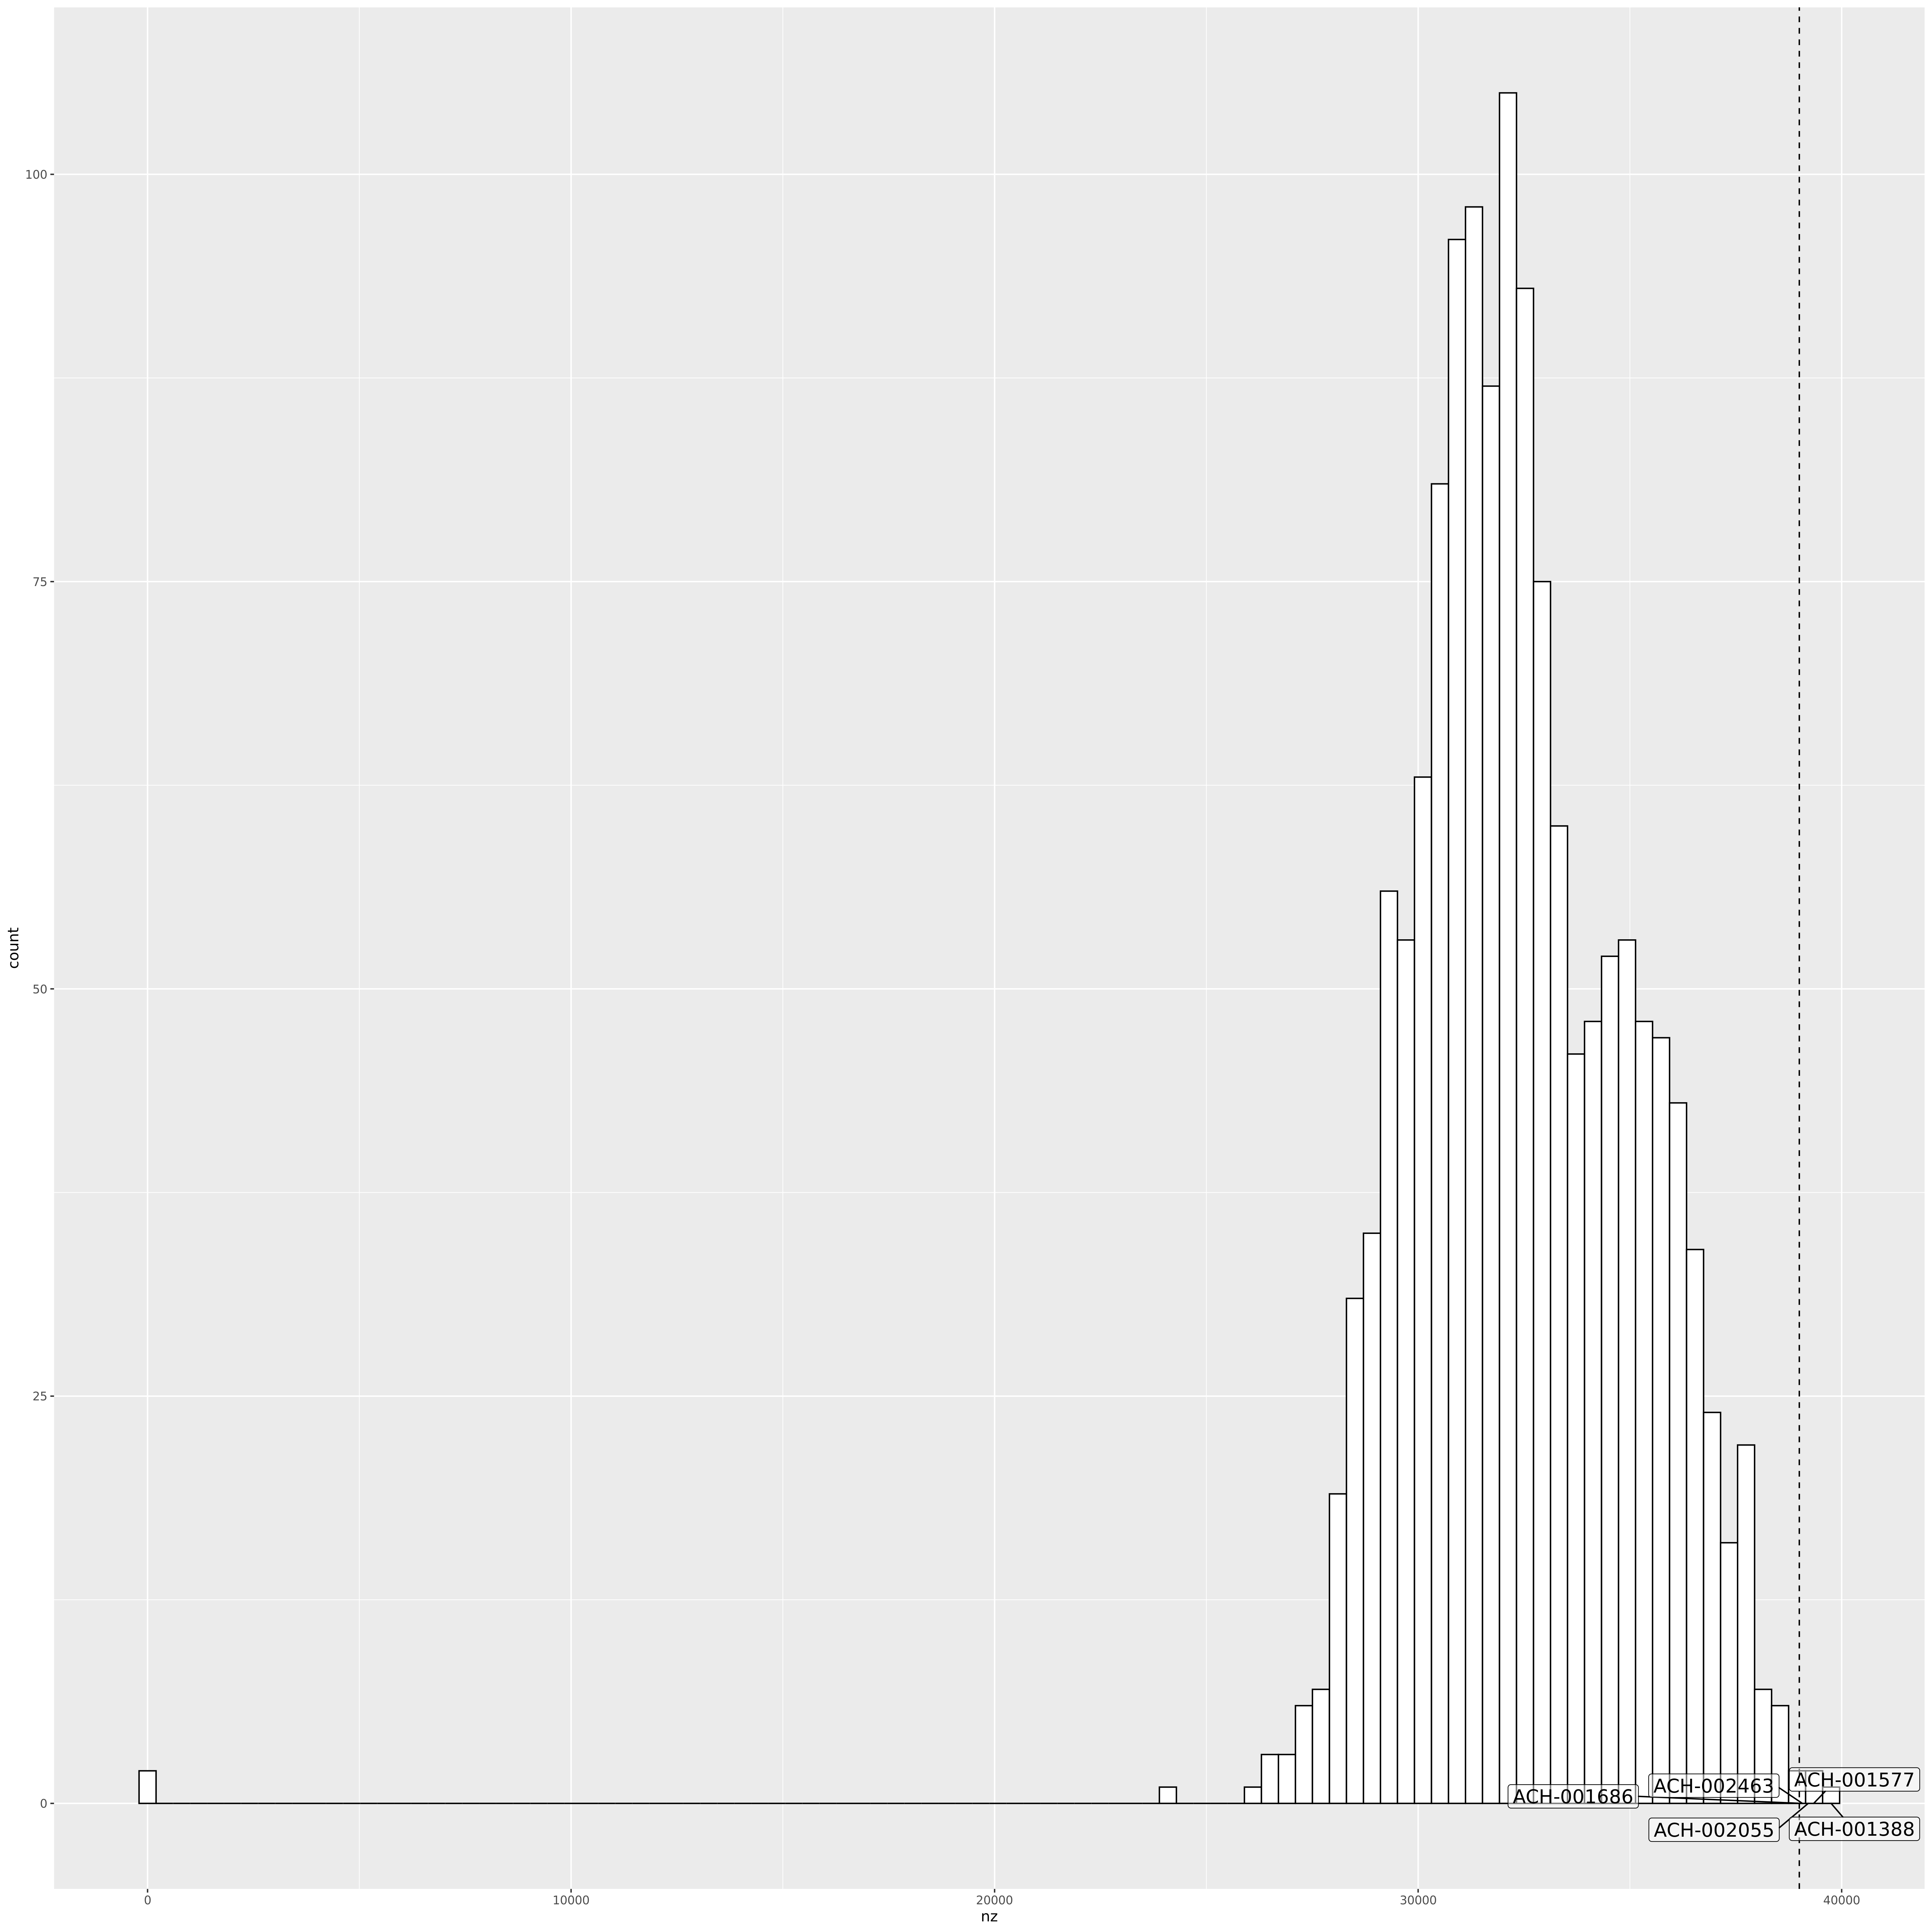

In [24]:
display(Image(filename='temp/ggplot.png'))

### Allie post processing 

In [25]:
%%R
colnames(tpm_transcripts)[which(colnames(tpm_transcripts)=='transcript')] <- 'transcript_id(s)'
colnames(tpm_genes)[which(colnames(tpm_genes)=='transcript')] <- 'transcript_id(s)'
colnames(counts_genes)[which(colnames(counts_genes)=='transcript')] <- 'transcript_id(s)'

In [26]:
%%R
print(colnames(tpm_genes)[1:10])
tpm_gene_ids <- gsub("\\..*", "", tpm_genes$gene_id)
if(nrow(tpm_genes) != length(unique(tpm_gene_ids))){
  print("Duplicated ensembl ids")
  print(nrow(tpm_genes) - length(unique(tpm_gene_ids)))
  tpm_genes <- tpm_genes[-which(duplicated(tpm_gene_ids)==T),]
}

 [1] "gene_id"          "transcript_id(s)" "ACH-001097"       "ACH-002466"      
 [5] "ACH-002467"       "ACH-001636"       "ACH-001679"       "ACH-001698"      
 [9] "ACH-002022"       "ACH-001804"      
[1] "Duplicated ensembl ids"
[1] 45


In [27]:
%%R
annotations<-download.raw.from.taiga(data.name='gene-annotations-e737', data.version=1, data.file='gencode.v29.annotation')
tpm_protein_coding <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=T, gencode_annotations=annotations)
tpm_genes <- prepare_depmap_TPM_for_taiga(tpm_genes, log_transform=T, just_protein_coding=F, gencode_annotations=annotations)

Fetching https://cds.team/taiga/api/dataset/gene-annotations-e737/1 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  ~/.taiga/gene-annotations-e737_1.toc 
Checking for cached file ~/.taiga/ed503071a3944c3f8ad7c1a4e1680240_gencode-v29-annotation.raw 
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "using 19144 protein coding genes"
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"


In [28]:
%%R
### transcripts
library('cdsomics')
print(colnames(tpm_transcripts)[1:10])
tpm_transcript_id <- gsub("\\..*", "", tpm_transcripts$`transcript_id`)
if(nrow(tpm_transcripts) != length(unique(tpm_transcript_id))) {
  print("Duplicated transcript ids")
  print(nrow(tpm_transcripts) - length(unique(tpm_transcript_id)))
  tpm_transcript <- tpm_transcripts[-which(duplicated(tpm_transcript_id)==T),]
}
tpm_transcripts <- prepare_depmap_transcripts_for_taiga(tpm_transcript, gencode_annotations = annotations) 

 [1] "transcript_id" "gene_id"       "ACH-001097"    "ACH-002466"   
 [5] "ACH-002467"    "ACH-001636"    "ACH-001679"    "ACH-001698"   
 [9] "ACH-002022"    "ACH-001804"   
[1] "Duplicated transcript ids"
[1] 160


In [29]:
%%R
### counts
print(colnames(counts_genes)[1:10])
counts_gene_ids <- gsub("\\..*", "", counts_genes$gene_id)
if(nrow(counts_genes) != length(unique(counts_gene_ids))) {
  print("Duplicate ensembl ids")
  print(length(which(duplicated(counts_gene_ids)==T)))
  counts_genes <- counts_genes[-which(duplicated(counts_gene_ids)==T),]
}
counts_genes <- prepare_depmap_TPM_for_taiga(counts_genes, gencode_annotations =annotations) 

 [1] "gene_id"          "transcript_id(s)" "ACH-001097"       "ACH-002466"      
 [5] "ACH-002467"       "ACH-001636"       "ACH-001679"       "ACH-001698"      
 [9] "ACH-002022"       "ACH-001804"      
[1] "Duplicate ensembl ids"
[1] 45
Fetching https://cds.team/taiga/api/dataset/hgnc-87ab/3 
Status 200 


R[write to console]: No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jeremie/.taiga/hgnc-87ab_3.toc 


R[write to console]: Loading from cached file /home/jeremie/.taiga/25d996d77e114d9c8c142ee48a90589f_hgnc-complete-set-2018q3.rds



[1] "1 duplicated ensembl ID(s)!"


In [30]:
%%R
write.table(
  counts_genes, 
  file = paste0('temp/expression.', release,'.counts'), 
  sep = '\t', quote = F)
write.table(
  tpm_genes, 
  file = paste0('temp/expression.', release,'.genes'), 
  sep = '\t', quote = F)
write.table(
  tpm_protein_coding, 
  file = paste0('temp/expression.', release,'.protein_coding'), 
  sep = '\t', quote = F)
write.table(
  tpm_transcripts, 
  file = paste0('temp/expression.', release,'.transcripts'),
  sep = '\t', quote = F)

## Loading

In [ ]:
counts_genes = pd.read_csv('temp/expression.'+ release + '.counts', sep='\t',index_col=0)
tpm_genes = pd.read_csv('temp/expression.'+ release + '.genes', sep='\t' ,index_col=0)
tpm_proteincoding = pd.read_csv('temp/expression.'+ release + '.protein_coding', sep='\t',index_col=0)
tpm_transcripts = pd.read_csv('temp/expression.'+ release + '.transcripts', sep='\t', index_col=0)

## validation


In [55]:
prevcounts = tc.get(name='depmap-expression-87f8', version=13, file="expression."+prevname+'.counts')
prevgenes = tc.get(name='depmap-expression-87f8', version=13, file="expression."+prevname+'.genes')
prevtranscripts = tc.get(name='depmap-expression-87f8', version=13, file="expression."+prevname+'.transcripts')
prevproteincoding = tc.get(name='depmap-expression-87f8', version=13, file="expression."+prevname+'.protein_coding')

KeyboardInterrupt: 

In [ ]:
def getNonZeroCorrelations(df1,df2):
    res=[]
    for k,val in df1.iterrows():
        if k in df2.index:
            corr = np.corrcoef(df1.loc[k],df2.loc[k])
            if corr[0,1]<0.99999999999999:
                res.append((k,corr[0,1]))
        else:
            print(k+" not in second df")
    print("found "+str(len(res))+" samples that did not match")
    return res

In [ ]:
unmatched = getNonZeroCorrelations(counts_genes ,prevcounts)

In [ ]:
unmatched

In [ ]:
# Is it because of  duplicate version?
rnasamples = ccle_refsamples[ccle_refsamples.datatype=='rna']
for i,val in unmatched:
    print(len(rnasamples[rnasamples.arxspan_id==i]))

In [ ]:
# <20million (~10million)
removedfromPiPelineNotEnoughReads = ['CDS-ABH0uZ','CDS-fk564T','CDS-kU30H5']

In [ ]:
notinnew = set(prevcounts.index) - set(counts_genes.index)
notinnew

In [ ]:
removedFromListNotEnoughExpressedGenes = ["ACH-001577", "ACH-001686", "ACH-002463", "ACH-002055", "ACH-001388", "ACH-000052"]

### replacing different values

In [ ]:
counts_genes = counts_genes.T
tpm_genes = tpm_genes.T
tpm_proteincoding = tpm_proteincoding.T
tpm_transcripts = tpm_transcripts.T

In [ ]:
for k, _ in unmatched+[('ACH-000561','')]:
    counts_genes[k] = prevcounts.loc[k].values
    tpm_genes[k] = prevgenes.loc[k].values
    tpm_proteincoding[k] = prevproteincoding.loc[k].values
    tpm_transcripts[k] = prevtranscripts.loc[k].values

In [ ]:
counts_genes = counts_genes.T
tpm_proteincoding = tpm_proteincoding.T
tpm_genes = tpm_genes.T
tpm_transcripts = tpm_transcripts.T

### Some predictions

In [ ]:
metadata = tc.get(name='depmap-a0ab', file='sample_info')

In [ ]:
metadata

In [ ]:
# finding train and test set
trainame = [val for val in new1&prev if val[:3] == 'ACH']
testname = [val for val in new1-prev if val[:3] == 'ACH']

#looking at the 2000 most variable genes in the two sets
genetolookfor = 2000
gene_var = counts_genes[trainame].var(1).values
print(len(gene_var))
sorting = np.argsort(gene_var)[-genetolookfor:]

In [ ]:
unregistered = set(testname) - set(metadata["DepMap_ID"].values.tolist())
unregistered

In [ ]:
len(counts_genes['ACH-001767']) - np.count_nonzero(counts_genes['ACH-001767'].values)

In [ ]:
# creating and reodering train and test sets
traindata = counts_genes[set(trainame)-unregistered].values[sorting].T
trainlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(trainame)-unregistered].columns.tolist() if val not in unregistered]

testdata = counts_genes[set(testname)-unregistered].values[sorting].T
testlabels = [metadata[metadata["DepMap_ID"]==val]["disease"].values[0] for val in counts_genes[set(testname)-unregistered].columns.tolist() if val not in unregistered]

In [ ]:
traindata.shape

In [ ]:
# learn KNN classifier to the metadata diseases
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(traindata, trainlabels) 
predicted = neigh.predict(testdata)

In [ ]:
predicted[1]

In [ ]:
labels = trainlabels + testlabels
colors=[0]*len(trainlabels)
colors.extend([1,2,2,2,2,1,2,2,2,1,2])
data = np.vstack([traindata,testdata])

In [ ]:
# plot them with TSNE, highlight the points that failed and show colors for diseases
dimred = TSNE(2,10).fit_transform(data)

In [ ]:
scatter(dimred, labels=labels,colors=colors, radi=1.9)

## Save files for taiga

In [ ]:
! ls temp/expression.*

In [ ]:
# FOR 20Q3 KNOW THAT WE WILL RETRIEVE DATA FROM 20Q2 WITH THE VERY DFFERENT CELL LINES!!

In [ ]:
tc.update_dataset(dataset_permaname="depmap-expression-87f8",
                 upload_file_path_dict={'temp/expression.'+release+'.transcripts.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.genes.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.counts.tsv': 'NumericMatrixTSV',
                                       'temp/expression.'+release+'.protein_coding.tsv': 'NumericMatrixTSV'},
                  dataset_description=
"""
# RNAseq

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, not log2 transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-8: guillaume releases
version 9: 19Q3 release
version 10:  adding missing samples in Terra merge files
version 11: 19Q4 new release.

Adding 93 new cell lines. 
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - having too many..
 
version 12:
    uploading as matrices 
    
version 13:
    20Q1 new release. 
    
version 14:
    20Q2 new release, adding 50 new samples
 
transcriptions (Transcripts rpkm):

genes (gene rpkm):
__Rows__:
__Columns__:
Counts (gene counts):
__Rows__:
__Columns__:
Gene level CN data:
__Rows__:
__Columns__:
 DepMap cell line IDs
 gene names in the format HGNC\_symbol (Entrez\_ID)
DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean
""")

In [27]:
prevprevcells = set(tc.get(name='depmap-rnaseq-expression-data-363a', file='internal_'+prevprevname+'_proteincoding_tpm',version=prevprevversion).index.tolist())

In [28]:
gsheets = sheets.get(privacy_release_url).sheets[6].to_frame()
rna_ibm_embargo = [i for i in gsheets['RNAseq_IBM_embargo'].values.tolist() if i is not np.nan]
rna_dmc_embargo = [i for i in gsheets['RNAseq_DMC_embargo'].values.tolist() if i is not np.nan]
blacklist = [i for i in gsheets['blacklist'].values.tolist() if i is not np.nan]

In [ ]:
blacklist, rna_dmc_embargo, rna_ibm_embargo

### internal

In [50]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(blacklist)]
print(len(counts_genes))
#counts_genes.to_csv('temp/internal_'+release+'_counts', sep='\t')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(blacklist)]
print(len(tpm_genes))
#tpm_genes.to_csv('temp/internal_'+release+'_tpm', sep='\t')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(blacklist)]
print(len(tpm_proteincoding))
#tpm_proteincoding.to_csv('temp/internal_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(blacklist)]
print(len(tpm_transcripts))
#tpm_transcripts.to_csv('temp/internal_'+release+'_transcripts_tpm', sep='\t')

1420
1414
1420
1414
1420
1414
1420
1414


In [ ]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-363a",
                 upload_file_path_dict={'temp/internal_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/internal_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# INTERNAL RNA

* Version 1-3 Internal 18Q1*

All CCLE cell lines with RNAseq data.

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_reads_20180201.gct`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18Q1_RNAseq_RPKM_20180201.gct`

Version 2 of RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1))

* Version 4-6 Internal 18Q2*

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_reads_20180420.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q2_RNAseq_RPKM_20180420.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

* Version 7 Internal 18Q2*

Includes a matrix with genes filtered by HGNC protein-coding gene locus group.

* Version 8-10 Internal 18Q3*

use version 10

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_reads_20180716.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_depMap_18q3_RNAseq_RPKM_20180716.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs.

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 9 updates names, and slightly different RPKM values due to randomly added noisy floor (using a seed of 4)

version 10 removes duplicate gene names from the protein coding datasets

* Version 11-12 Internal 18Q4*

18Q4 transcript level data is found in version 14. (In versions 1-13 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_reads_20181029.gct` `/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_RNAseq_RPKM_20181029.gct`

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added. The TPM data contains 4 cell lines not included in the RPKM data.

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID)

* Version 13-15 Internal 19Q1*

Version 15 contains the correct data sets for 19Q1 - 2 cell lines are removed

Version 14 contains the correct transcript level data for 18Q4

* Version 16 Internal 19Q2*

* Version 17 Internal 19Q3*

* Version 18 Internal 19Q4

Adding 93 new cell lines - Blacklisted
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
* Version 19 Internal 19Q4
removing blacklisted

* Version 20 Internal 19Q4
removing blacklisted in transcripts

* Version 21 Internal 19Q4
uploading as matrices 

* Version 21 Internal 20Q1
adding 6 new cell lines

* Version 22 Internal 20Q2
adding  new cell lines

data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

In [ ]:
AddToVirtual('depmap-a0ab', "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

AddToVirtual(virtual_internal, "depmap-rnaseq-expression-data-363a", files=[('CCLE_RNAseq_reads', 'internal_'+release+'_counts'),('CCLE_expression_full', 'internal_'+release+'_tpm'),('CCLE_expression', 'internal_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'internal_'+release+'_transcripts_tpm')])

### IBM

like internal

### DMC

In [51]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[~counts_genes.index.isin(rna_ibm_embargo)]
print(len(counts_genes))
counts_genes.to_csv('temp/dmc_'+release+'_counts', sep='\t')
print(len(tpm_genes))
tpm_genes = tpm_genes[~tpm_genes.index.isin(rna_ibm_embargo)]
print(len(tpm_genes))
tpm_genes.to_csv('temp/dmc_'+release+'_tpm', sep='\t')
print(len(tpm_proteincoding))
tpm_proteincoding = tpm_proteincoding[~tpm_proteincoding.index.isin(rna_ibm_embargo)]
print(len(tpm_proteincoding))
tpm_proteincoding.to_csv('temp/dmc_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_ibm_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/dmc_'+release+'_transcripts_tpm', sep='\t')

1414
1387
1414
1387
1414
1387
1414
1387


In [52]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-80ef",
                 upload_file_path_dict={'temp/dmc_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/dmc_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# DMC RNA

* Version 1-3 DMC 19Q1*

version 3 contains the correct data for 19Q1

version 2 contains correct TPM transcript data (in version 1 transcript data contains only gene level not transcript level data)

* Version 4 DMC 19Q2*

* Version 5 DMC 19Q3*

* Version 6 DMC 19Q4*

Adding 93 new cell lines - Blacklisted - IBM
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None

* Version 7 DMC 19Q4

removing blacklisted

* Version 8 DMC 19Q4

removing blacklisted in transcripts

* Version 9 DMC 19Q4

uploading as numeric matrix

* Version 10 DMC 20Q1

* Version 11 DMC 20Q2
adding  new cell lines


data is aligned to hg38

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

Uploading dmc_20Q2_counts...
hitting https://cds.team/taiga/api/datafile/479d18e13cad436c8c42d55699bfb9b0
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 5

	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 750
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1000
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Conversion in progress, line 1250
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S

	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 250
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in progress, line 500
	 Conversion in prog

	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploadin

	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploadin

'6aef3f255d4e455ba7b997a0bde613d3'

In [53]:
AddToVirtual(virtual_dmc, "depmap-rnaseq-expression-data-80ef", files=[('CCLE_RNAseq_reads', 'dmc_'+release+'_counts'),('CCLE_expression_full', 'dmc_'+release+'_tpm'),('CCLE_expression', 'dmc_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'dmc_'+release+'_transcripts_tpm')])

[('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_counts'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_tpm'), ('CCLE_expression', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_proteincoding_tpm'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_transcripts_tpm'), ('CCLE_gene_cn', 'depmap-cn-data-9b9d.12/dmc_20Q2_gene_cn'), ('CCLE_segment_cn', 'depmap-cn-data-9b9d.12/dmc_20Q2_segs_cn')]
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datafile/29031642815546ab8c3def1030f1b042
hitting https://cds.team/taiga/api/datasetVersion

Dataset version w

### public

In [54]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(counts_genes))
counts_genes = counts_genes[counts_genes.index.isin(prevprevcells)]
print(len(counts_genes))
counts_genes[~counts_genes.index.isin(rna_dmc_embargo)].to_csv('temp/public_'+release+'_counts', sep='\t')
tpm_genes = tpm_genes[tpm_genes.index.isin(prevprevcells)]
print(len(tpm_genes))
tpm_genes[~tpm_genes.index.isin(rna_dmc_embargo)].to_csv('temp/public_'+release+'_tpm', sep='\t')
tpm_proteincoding = tpm_proteincoding[tpm_proteincoding.index.isin(prevprevcells)]
print(len(tpm_proteincoding))
tpm_proteincoding[~tpm_proteincoding.index.isin(rna_dmc_embargo)].to_csv('temp/public_'+release+'_proteincoding_tpm', sep='\t')
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[tpm_transcripts.index.isin(prevprevcells)]
print(len(tpm_transcripts))
tpm_transcripts = tpm_transcripts[~tpm_transcripts.index.isin(rna_dmc_embargo)]
print(len(tpm_transcripts))
tpm_transcripts.to_csv('temp/public_'+release+'_transcripts_tpm', sep='\t')

1387
1336


KeyboardInterrupt: 

In [ ]:
tc.update_dataset(dataset_permaname="depmap-rnaseq-expression-data-ccd0",
                 upload_file_path_dict={'temp/public_'+release+'_counts': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_tpm': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_proteincoding_tpm': 'NumericMatrixTSV',
                                       'temp/public_'+release+'_transcripts_tpm': 'NumericMatrixTSV'},
                  dataset_description=
"""
# PUBLIC RNA

* Version 1-2 Public 18Q1*

Original source (`CCLE_DepMap_18Q1_RNAseq_reads_20180214.gct`, `CCLE_DepMap_18Q1_RNAseq_RPKM_20180214.gct`) downloaded from portals.broadinstitute.org/ccle
RPKM file is log2(RPKM) with a "noisy floor" around -3 (-3 + N(0, 0.1))

* Version 3-5 Public 18Q2*

gene expression data (RNAseq for1,076 cell lines, including data for 28 newly released cell lines)

original source: (`/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_RPKM_20180502.gct`, `/xchip/ccle_dist/public/DepMap_18Q2/CCLE_DepMap_18Q2_RNAseq_reads_20180502.gct`)
* Version 6-7 Public 18Q3*

gene expression data (80 newly released cell lines)

Original data source:

`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_reads_20180718.gct`
`/xchip/ccle_dist/public/DepMap_18Q3/CCLE_DepMap_18q3_RNAseq_RPKM_20180718.gct`

RPKM data are log2-transformed with a noisy floor at -3 (-3 + N(0, 0.1)). Reads file unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are Broad (Arxspan) cell line IDs. Mapping between Broad IDs and CCLE IDs can be done using a R or python package

To install R implementation: options(repos = c("https://iwww.broadinstitute.org/~datasci/R-packages", "https://cran.cnr.berkeley.edu")) install.packages('celllinemapr')

To install python implementation: pip install https://intranet.broadinstitute.org/~datasci/python-packages/cell_line_mapper-0.1.9.tar.gz)

Columns: In the complete RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding RPKM and read datasets column names are HGNC_symbol (Entrez_ID)

version 7 removes duplicate gene names from the protein coding datasets

* Version 8-9 Public 18Q4*

_ 18Q4 transcript level data is found in version 11. (In versions 8-9 transcript data contains only gene level not transcript level data)

changing to TPM expression

Original data source:

`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_genes_tpm_20181029.txt`
`/xchip/ccle_dist/broad_only/CMAG/expression/CCLE_DepMap_18Q4_rsem_transcripts_tpm_20181029.gct`
`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_reads_20181029.gct`

`/xchip/ccle_dist/public/DepMap_18Q4/CCLE_DepMap_18q4_RNAseq_RPKM_20181029.gct`

TPM data is subsetted to just public cell lines using the cell line found in the RPKM dataset.

TPM data is the primary expression data now. It is log2-transformed with a pseudo count of 1 added

RPKM data are log2-transformed with a pseudo count of 1 added. RPKM values are no longer thresholded.

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap (Arxspan) cell line IDs

Columns: In the complete TPM, TPM transcripts, RPKM and read datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM and read datasets column names are HGNC_symbol (Entrez_ID)

* Version 10-12 Public 19Q1*

version 12 contains the correct data for 19Q1

version 11 contains the correct transcript level data for 19Q1 and 18Q4

* Version 13 Public 19Q2*

* Version 14 Public 19Q3*

* Version 15 Public 19Q4*
Adding 93 new cell lines - Blacklisted - IBM - DMC
Some cells lines have been removed because they:

 - had too many 0 values = ["ACH-001388" "ACH-001577" "ACH-001767" "ACH-002463"] 

Some cells lines have been flagged as:

 - None
 
* Version 16 Public 19Q4*
removing unauthorized cell lines

* Version 17 Public 20Q1*
adding 6 new lines

* Version 18 Public 20Q2
adding  new cell lines

data is hg38 aligned

read count data is created using RSEM, which, when a read maps to multiple places, splits the counts between genes, with the weight based on the likelihood that it came from one gene or the other, so counts data may not be integers

TPM data is log2-transformed with a pseudo count of 1 added. log2(X+1)

Reads/transcript files unaltered aside from formatting row / column names.

The ProteinCoding datasets contain just protein coding genes and are based on protein coding annotations from https://www.genenames.org/cgi-bin/download (locus_group == "protein-coding gene")

Rows: are DepMap cell line IDs

Columns: In the complete TPM and read counts datasets column names are HGNC_symbol (Ensembl_ID), while in the ProteinCoding TPM dataset column names are HGNC_symbol (Entrez_ID). In the TPM transcript dataset column names are HGNC_symbol (Transcript_ID) - the HGNC symbols are not unique, use the transcript IDs for unique identifiers.
""")

In [ ]:
AddToVirtual(virtual_public, "depmap-rnaseq-expression-data-ccd0", files=[('CCLE_RNAseq_reads', 'public_'+release+'_counts'),('CCLE_expression_full', 'public_'+release+'_tpm'),('CCLE_expression', 'public_'+release+'_proteincoding_tpm'),('CCLE_RNAseq_transcripts', 'public_'+release+'_transcripts_tpm')])

## Fusion post processing

In [ ]:
terra.waitForSubmission(refworkspace, submission_id2)

In [ ]:
submission_id2 = refwm.create_submission("Aggregate_Fusion_Calls", 'All_samples')
terra.waitForSubmission(refworkspace, submission_id2)

In [7]:
aggregated = refwm.get_sample_sets().loc['All_samples']['fusions_star']

In [8]:
! gsutil cp $aggregated "temp/expression.fusion.tsv"

Copying gs://fc-secure-639c94ba-2b0d-4960-92fc-9cd50046a968/b115f965-c3e0-4b23-b5f9-c879743bb6f1/aggregate_set_files_workflow/5cc04c26-b28a-4ccb-a3e3-82650b775d22/call-aggregate_set_files/attempt-3/Fusions.aggregated.tsv...
| [1 files][ 96.9 MiB/ 96.9 MiB]                                                
Operation completed over 1 objects/96.9 MiB.                                     


In [12]:
file = pd.read_csv('temp/expression.fusion.tsv', header=0, sep='\t', quotechar='"', error_bad_lines=False, index_col=None)
file["DepMap_ID"] = [i.split('.')[0] for i in file['DepMap_ID']]

,DepMap_ID,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots
0,CDS-010xbm.star-fusion.fusion_predictions.abri...,ADAM17--ITGB1BP1,44,94,ONLY_REF_SPLICE,ADAM17^ENSG00000151694.13,chr2:9543153:-,ITGB1BP1^ENSG00000119185.12,chr2:9414256:-,YES_LDAS,2.1455,GT,1.9086,AG,1.8892,"[""TCGA_StarF2019"",""INTRACHROMOSOMAL[chr2:0.06M..."
1,CDS-010xbm.star-fusion.fusion_predictions.abri...,CACNA2D1--SEMA3E,48,53,ONLY_REF_SPLICE,CACNA2D1^ENSG00000153956.15,chr7:82335135:-,SEMA3E^ENSG00000170381.13,chr7:83469302:-,YES_LDAS,1.5703,GT,1.9899,AG,1.9899,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr7:0.92M..."
2,CDS-010xbm.star-fusion.fusion_predictions.abri...,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2^ENSG00000101544.8,chr18:80117650:+,PLIN3^ENSG00000105355.8,chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr..."
3,CDS-010xbm.star-fusion.fusion_predictions.abri...,XRCC4--SUGCT,23,104,ONLY_REF_SPLICE,XRCC4^ENSG00000152422.15,chr5:83111203:+,SUGCT^ENSG00000175600.15,chr7:40749434:+,YES_LDAS,1.9745,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr5--chr7]""]"
4,CDS-010xbm.star-fusion.fusion_predictions.abri...,DHX40--VMP1,28,48,ONLY_REF_SPLICE,DHX40^ENSG00000108406.9,chr17:59588053:+,VMP1^ENSG00000062716.12,chr17:59839768:+,YES_LDAS,1.1816,GT,1.8892,AG,1.7819,"[""TCGA_StarF2019"",""CCLE_StarF2019"",""INTRACHROM..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376246,CDS-zx92JS.star-fusion.fusion_predictions.abri...,UMAD1--GLCCI1,1,1,ONLY_REF_SPLICE,UMAD1^ENSG00000219545.11,chr7:7673453:+,GLCCI1^ENSG00000106415.12,chr7:8003908:+,NO_LDAS,0.0182,GT,1.8295,AG,1.7465,"[""GTEx_recurrent_StarF2019"",""INTRACHROMOSOMAL[..."
376247,CDS-zx92JS.star-fusion.fusion_predictions.abri...,VAPB--APCDD1L-DT,1,1,ONLY_REF_SPLICE,VAPB^ENSG00000124164.15,chr20:58418363:+,APCDD1L-DT^ENSG00000231290.5,chr20:58523169:+,YES_LDAS,0.0182,GT,1.8323,AG,1.9656,"[""INTRACHROMOSOMAL[chr20:0.06Mb]"",""NEIGHBORS[6..."
376248,CDS-zx92JS.star-fusion.fusion_predictions.abri...,VAPB--APCDD1L-DT,1,1,ONLY_REF_SPLICE,VAPB^ENSG00000124164.15,chr20:58418363:+,APCDD1L-DT^ENSG00000231290.5,chr20:58618740:+,YES_LDAS,0.0182,GT,1.8323,AG,1.9086,"[""INTRACHROMOSOMAL[chr20:0.06Mb]"",""NEIGHBORS[6..."
376249,CDS-zx92JS.star-fusion.fusion_predictions.abri...,VTI1A--AL158212.1,1,1,ONLY_REF_SPLICE,VTI1A^ENSG00000151532.13,chr10:112668998:+,AL158212.1^ENSG00000225292.2,chr10:112888735:+,NO_LDAS,0.0182,GT,1.7465,AG,1.8892,"[""GTEx_recurrent_StarF2019"",""INTRACHROMOSOMAL[..."


In [18]:
print(len(file))
renaming = removeOlderVersions(names=set(file['DepMap_ID']), refsamples=refwm.get_samples(), arxspan_id="arxspan_id", version="version")
file = file[file['DepMap_ID'].isin(renaming.keys())].replace({'DepMap_ID':renaming}).reset_index(drop=True)
print(len(file))
print(file['DepMap_ID'][:10])
file.to_csv('temp/expression.fusion.tsv', sep='\t')

0    ACH-001113
1    ACH-001113
2    ACH-001113
3    ACH-001113
4    ACH-001113
5    ACH-001113
6    ACH-001113
7    ACH-001113
8    ACH-001113
9    ACH-001113
Name: DepMap_ID, dtype: object


### Overview

This document contains the code used to generate the unfiltered and filtered versions of the fusion datasets for the release. The bottom of the document also contains some comparisons between the release fusion dataset, CCLE2 fusion calls, and the translocation data from CCLE2.

In [21]:
%%R
source('../gkugener/RScripts/load_libraries_and_annotations.R')
source("src/CCLE_postp_function.R")
library('cdsomics')

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ stringr 1.4.0
✔ tidyr   1.0.0     ✔ forcats 0.4.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr

R[write to console]: Loading required package: graph

R[write to console]: 
Attaching package: ‘graph’


R[write to console]: The following object is masked from ‘package:XML’:

    addNode


R[write to console]: The following object is masked from ‘package:stringr’:

    boundary


R[write to console]: The following object is masked from ‘package:plyr’:

    join


R[write to console]: Loading required package: RCurl

R[write to console]: Loading required package: bitops

R[write to console]: 
Attaching package: ‘RCurl’


R[write to console]: The following object is masked from ‘package:tidyr’:

    complete


R[write to console]: Loading required package: httr

R[write to console]: 
Attaching package: ‘httr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    content


R[write to console]: The following object is masked from ‘package:plotly’:

    config


R[write to console]: Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R pa

## Generate filtered fusion table

Release: `r release`

We want to apply filters to the fusion table to reduce the number of artifacts in the dataset. Specifically, we filter the following:

* Remove fusions involving mitochondrial chromosomes, or HLA genes, or immunoglobulin genes
* Remove red herring fusions (from STAR-Fusion annotations column)
* Remove recurrent in CCLE (>= 25 samples)
* Remove fusion with (SpliceType=" INCL_NON_REF_SPLICE" and LargeAnchorSupport="No" and FFPM < 0.1)
* Remove fusions with FFPM < 0.05 (STAR-Fusion suggests using 0.1, but looking at the translocation data, this looks like it might be too aggressive)

with the functions:
- readFusions
- filterFusions
- prepare_depmap_fusion_data_for_taiga

In [22]:
%%R
unfiltered_fusions <- readFusions('temp/expression.fusion.tsv')
filtered_fusions <- filterFusions(unfiltered_fusions)

filtered_fusions <- prepare_depmap_fusion_data_for_taiga(filtered_fusions)
unfiltered_fusions <- prepare_depmap_fusion_data_for_taiga(unfiltered_fusions)

filtered_fusions <- filtered_fusions[,2:ncol(filtered_fusions)]
unfiltered_fusions <- unfiltered_fusions[,2:ncol(unfiltered_fusions)]

In [23]:
%%R
# Save the files (to be uploaded to taiga)
write.table(
  unfiltered_fusions,
  file = paste0('temp/fusions.',release, '.unfiltered'),
  sep = '\t', quote = F, row.names = F
)
write.table(
  filtered_fusions,
  file = paste0('temp/fusions.', release, '.filtered'),
  sep = '\t', quote = F, row.names = F
)

## Validation

### Validation Protocol:

to validate fusions, one should be able to list all cells with known fusions (i.e. elwing sarcoma) and check for each new cell in this set of knownfusioncells, if the fusion is present or not. and validate the fusion quality this way.

In [31]:
unfiltered = pd.read_csv('temp/fusions.'+release+'.unfiltered', sep='\t',index_col=None)
filtered = pd.read_csv('temp/fusions.'+ release+'.filtered',sep='\t',index_col=None)

In [37]:
filtered

,DepMap_ID,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,CCLE_count
0,ACH-001113,CACNA2D1--SEMA3E,48,53,ONLY_REF_SPLICE,CACNA2D1 (ENSG00000153956),chr7:82335135:-,SEMA3E (ENSG00000170381),chr7:83469302:-,YES_LDAS,1.5703,GT,1.9899,AG,1.9899,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr7:0.92M...",2
1,ACH-001113,ADNP2--PLIN3,50,40,INCL_NON_REF_SPLICE,ADNP2 (ENSG00000101544),chr18:80117650:+,PLIN3 (ENSG00000105355),chr19:4867657:-,YES_LDAS,1.3993,GT,1.7819,AG,1.8323,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr18--chr...",2
2,ACH-001113,XRCC4--SUGCT,23,104,ONLY_REF_SPLICE,XRCC4 (ENSG00000152422),chr5:83111203:+,SUGCT (ENSG00000175600),chr7:40749434:+,YES_LDAS,1.9745,GT,1.9656,AG,1.9656,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr5--chr7]""]",2
3,ACH-001113,PCYT1A--RBFOX1,26,48,ONLY_REF_SPLICE,PCYT1A (ENSG00000161217),chr3:196247367:-,RBFOX1 (ENSG00000078328),chr16:6654603:+,YES_LDAS,1.1505,GT,1.7819,AG,1.8295,"[""CCLE_StarF2019"",""INTERCHROMOSOMAL[chr3--chr1...",4
4,ACH-001113,AF117829.1--PIP4P2,25,31,ONLY_REF_SPLICE,AF117829.1 (ENSG00000251136),chr8:89757045:-,PIP4P2 (ENSG00000155099),chr8:90996744:-,YES_LDAS,0.8707,GT,1.8062,AG,1.9329,"[""INTRACHROMOSOMAL[chr8:1.24Mb]""]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35765,ACH-000052,SMURF2P1--SP2,5,21,ONLY_REF_SPLICE,SMURF2P1 (ENSG00000248121),chr17:30610942:+,SP2 (ENSG00000167182),chr17:47914726:+,YES_LDAS,0.2356,GT,1.7819,AG,1.7819,"[""CCLE_StarF2019"",""INTRACHROMOSOMAL[chr17:17.2...",2
35766,ACH-000052,AP002990.1--UBXN1,4,6,ONLY_REF_SPLICE,AP002990.1 (ENSG00000255508),chr11:62572584:-,UBXN1 (ENSG00000162191),chr11:62677005:-,YES_LDAS,0.0906,GT,1.9329,AG,1.9656,"[""INTRACHROMOSOMAL[chr11:0.08Mb]"",""LOCAL_REARR...",2
35767,ACH-000052,EEF1G--UBXN1,4,6,ONLY_REF_SPLICE,EEF1G (ENSG00000254772),chr11:62572584:-,UBXN1 (ENSG00000162191),chr11:62677005:-,YES_LDAS,0.0906,GT,1.9329,AG,1.9656,"[""Klijn_CellLines"",""INTRACHROMOSOMAL[chr11:0.1...",2
35768,ACH-000052,AC093484.3--FN1,4,3,INCL_NON_REF_SPLICE,AC093484.3 (ENSG00000265401),chr17:16382422:-,FN1 (ENSG00000115414),chr2:215391753:-,YES_LDAS,0.0634,TG,1.8892,AC,1.5546,"[""INTERCHROMOSOMAL[chr17--chr2]""]",14


## Uploading to Taiga

In [42]:
tc.update_dataset(dataset_permaname="depmap-fusions-7990",
                     upload_file_path_dict={'temp/fusions.'+release+'.filtered': 'TableTSV',
                                        'temp/fusions.'+release+'.unfiltered': 'TableTSV'},
                 dataset_description="""
# Fusions

filtered and unfiltered fusion files from Broad RNAseq data mapped to hg38

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

version 1-4: guillaume releases
version 5: 19Q3 release
version 6:  adding missing samples in Terra merge files

## ** version 7 Internal 19Q4****
Adding 17 new cell lines, 3 reprioritized cell lines. log2(COPY RATIO+1). 
Some cells lines have been flagged as:

## ** version 8 Internal 20Q1****
Adding 6 new lines

## ** version 9 Internal 20Q2****
Adding 50 new lines

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05
""")

Uploading fusions.20Q2...
hitting https://cds.team/taiga/api/datafile/d5a7d35a38794875b24166639707aa0f
Conversion and upload...:
	 Uploading to S3

	 Done: fusions.20Q2 properly converted and uploaded
Uploading fusions.20Q2...
hitting https://cds.team/taiga/api/datafile/d5a7d35a38794875b24166639707aa0f
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: fusions.20Q2 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion


Exception: Bad status code: 500

### Internal

In [ ]:
filtered

In [33]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(blacklist)]
print(len(filtered))
filtered.to_csv('temp/filtered_fusions_'+release, sep='\t', index=False)
print(len(unfiltered))
unfiltered= unfiltered[~unfiltered.DepMap_ID.isin(blacklist)]
print(len(unfiltered))
unfiltered.to_csv('temp/unfiltered_fusions_'+release, sep='\t', index=False)

35770
35478
359778
358959


In [34]:
tc.update_dataset(dataset_permaname="gene-fusions-8b7a",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# Internal Fusions

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

Version 3: added a column containing the Broad_ID

* Version 4-5 Internal 19Q1*

version 5 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 6 Internal 19Q2*

* Version 7*

Josh D added "common_fusion_matrix".

Binary matrix of the most common gene fusions (those where the two involved genes are fused in at least 5 cell lines) with no additional filtering. Use at your own risk.

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

* Version 8 Internal 19Q3*

* Version 8 Internal 19Q4*

* Version 8 Internal 20Q1*

* Version 8 Internal 20Q2*
Adding 50 new lines

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05

""")
AddToVirtual('depmap-a0ab', "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

AddToVirtual(virtual_internal, "gene-fusions-8b7a", files=[('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release),('CCLE_fusions', 'filtered_fusions_'+release)])

Uploading filtered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/63a94435779d4725992ab2135b6c21e4
Conversion and upload...:
	 Uploading to S3

	 Done: filtered_fusions_20Q2 properly converted and uploaded
Uploading unfiltered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/63a94435779d4725992ab2135b6c21e4
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: unfiltered_fusions_20Q2 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id ac4116fc4a9944ed9d9164c5ed1dda1c created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/ac4116fc4a9944ed9d9164c5ed1dda1c
[('CCLE_fusions_unfiltered', 'gene-fusions-8b7a.12/unfiltered_fusions_20Q2'), ('CCLE_fusions', 'gene-fusions

hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8
hitting https://cds.team/taiga/api/datafile/25394e1680bf487bbfde251ab4be22f8

### IBM

same as internal

### DMC

In [36]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[~filtered.DepMap_ID.isin(rna_ibm_embargo)]
filtered.to_csv('temp/filtered_fusions_'+release, sep='\t',index=False)

unfiltered  = unfiltered[~unfiltered.DepMap_ID.isin(rna_ibm_embargo)]
unfiltered.to_csv('temp/unfiltered_fusions_'+release, sep='\t',index=False)
print(len(unfiltered))

35478
35087
355420
355420


In [38]:
tc.update_dataset(dataset_permaname="gene-fusions-375f",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# DMC Fusions

* Version 1-2 DMC 19Q1*

version 2 contains the correct data for 19Q1

Description: Gene fusions derived from RNAseq data.

Rows: cell lines

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints

* Version 3 DMC 19Q2*

* Version 4 DMC 19Q3*

* Version 5 DMC 19Q4*

* Version 6 DMC 20Q1*

* Version 7 DMC 20Q2*
adding 50 new lines

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05
""")

Uploading filtered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/e1e24b4dca5d416895666c0667b32eef
Conversion and upload...:
	 Uploading to S3

	 Done: filtered_fusions_20Q2 properly converted and uploaded
Uploading unfiltered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/e1e24b4dca5d416895666c0667b32eef
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: unfiltered_fusions_20Q2 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id b38589626d1341098996986f97b47689 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/b38589626d1341098996986f97b47689


'b38589626d1341098996986f97b47689'

In [39]:
AddToVirtual(virtual_dmc, "gene-fusions-375f", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

[('CCLE_fusions', 'gene-fusions-375f.7/filtered_fusions_20Q2'), ('CCLE_fusions_unfiltered', 'gene-fusions-375f.7/unfiltered_fusions_20Q2'), ('CCLE_RNAseq_reads', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_counts'), ('CCLE_expression', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_proteincoding_tpm'), ('CCLE_gene_cn', 'depmap-cn-data-9b9d.12/dmc_20Q2_gene_cn'), ('CCLE_RNAseq_transcripts', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_transcripts_tpm'), ('CCLE_segment_cn', 'depmap-cn-data-9b9d.12/dmc_20Q2_segs_cn'), ('CCLE_expression_full', 'depmap-rnaseq-expression-data-80ef.11/dmc_20Q2_tpm')]
hitting https://cds.team/taiga/api/datafile/97ca1ef3569e42d589384dfc7dea7547
hitting https://cds.team/taiga/api/datafile/97ca1ef3569e42d589384dfc7dea7547
hitting https://cds.team/taiga/api/datafile/97ca1ef3569e42d589384dfc7dea7547
hitting https://cds.team/taiga/api/datafile/97ca1ef3569e42d589384dfc7dea7547
hitting https://cds.team/taiga/api/datafile/97ca1ef3569e42d589384dfc7dea7547
hittin

### Public

In [40]:
## removing first blacklisted, then embargoed, to create two datasets
print(len(filtered))
filtered = filtered[filtered.DepMap_ID.isin(prevprevcells)]
print(len(filtered))
filtered[~filtered.DepMap_ID.isin(rna_dmc_embargo)].to_csv('temp/filtered_fusions_'+release, sep='\t', index=False)

print(len(unfiltered))
unfiltered = unfiltered[unfiltered.DepMap_ID.isin(prevprevcells)]
print(len(unfiltered))
unfiltered[~unfiltered.DepMap_ID.isin(rna_dmc_embargo)].to_csv('temp/unfiltered_fusions_'+release, sep='\t', index=False)

35087
34087
355420
348149


In [41]:
tc.update_dataset(dataset_permaname="gene-fusions-6212",
                 upload_file_path_dict={'temp/filtered_fusions_'+release: 'TableTSV',
                                       'temp/unfiltered_fusions_'+release: 'TableTSV'},
                  dataset_description=
"""
# PUBLIC Fusions

* Version 1 Public 2017 data*

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, ID contained in the column Broad_ID

Original Raw Data: Generated by Mahmoud Ghandi on April 25, 2017. Can be found at xchip_ccle_dist/broad_only/unpublished_Novartis_data/RNAseq/fusions.txt

* Version 2-3 Public 19Q1*

version 3 contains the correct data for 19Q1

* Version 4-5 Public 19Q2*

in version 5 formatting of the columns is improved

* Version 6 Public 19Q3*

* Version 7 Public 19Q4*

* Version 8 Public 20Q1*

* Version 9 Public 20Q2*
adding 50 new lines

Description: Gene fusions derived from RNAseq data.

Rows: cell lines, IDs contained in the column DepMap_ID
LeftGene and RightGene separated by an ampersand ("&").

Unfiltered data contains all output fusions, while the filtered data uses the filters suggested by the star fusion docs. These filters are:
- FFPM > 0.1 -  a cutoff of 0.1 means&nbsp;at least 1 fusion-supporting RNAseq fragment per 10M total reads
- Remove known false positives, such as GTEx recurrent fusions and certain paralogs
- Genes that are next to each other
- Fusions with mitochondrial breakpoints
- Removing fusion involving mitochondrial chromosomes or HLA genes
- Removed common false positive fusions (red herring annotations as described in the STAR-Fusion docs)
- Recurrent fusions observed in CCLE across cell lines (in 25 or more samples)
- Removed fusions where SpliceType='INCL_NON_REF_SPLICE' and LargeAnchorSupport='NO_LDAS' and FFPM < 0.1
- FFPM < 0.05

""")
AddToVirtual(virtual_public, "gene-fusions-6212", files=[('CCLE_fusions', 'filtered_fusions_'+release),('CCLE_fusions_unfiltered', 'unfiltered_fusions_'+release)])

Uploading filtered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/5b461e144b6c4f86a7a0e6999b47f6c5
Conversion and upload...:
	 Uploading to S3

	 Done: filtered_fusions_20Q2 properly converted and uploaded
Uploading unfiltered_fusions_20Q2...
hitting https://cds.team/taiga/api/datafile/5b461e144b6c4f86a7a0e6999b47f6c5
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: unfiltered_fusions_20Q2 properly converted and uploaded
hitting https://cds.team/taiga/api/datasetVersion

Dataset version with id 108aa4628a634f429b15021aac0eb985 created. You can access to this dataset version directly with this url: https://cds.team/taiga/dataset_version/108aa4628a634f429b15021aac0eb985
[('CCLE_fusions', 'gene-fusions-6212.10/filtered_fusions_20Q2'), ('CCLE_fusions_unfiltered', 'gene-fusions-6

## [Additional] IF want to merge here instead of on Terra:

In [ ]:
newsamples

In [ ]:
prevsamplesets = ['CCLE_19Q3interim',samplesetname]
samples = []
for i in prevsamplesets:
    samples.extend(refwm.get_sample_sets().loc[i].samples)
res = []
terrasamp = refwm.get_samples()
for i, sample in enumerate(samples):
    res.append(terrasamp.loc[sample])
    genes_fusion = res[i]['fusion_predictions_abridged']
    rsem_genes_transcripts = res[i]['rsem_isoforms']
    rsem_genes_expected_count = res[i]['rsem_genes']
    ! gsutil cp $rsem_genes_expected_count 'temp/' && gsutil cp $rsem_genes_transcripts 'temp/' && gsutil cp $genes_fusion 'temp/'

In [ ]:
mainres = refwm.get_sample_sets().loc['DM19Q2_PATHS_CORRECTED_V2']
maingenes_fusion = mainres['fusions_star']
mainrsem_genes_tpm = mainres['rsem_genes_tpm']
mainrsem_genes_transcripts = mainres['rsem_transcripts_tpm']
mainrsem_genes_expected_count = mainres['rsem_genes_expected_count']
! gsutil cp $mainrsem_genes_expected_count "temp/" && gsutil cp $mainrsem_genes_transcripts "temp/" && gsutil cp $maingenes_fusion "temp/expression.fusion.tsv" && gsutil cp $mainrsem_genes_tpm "temp/"

In [ ]:
mainres['rsem_genes_expected_count']

In [ ]:
addSamplesRSEMToMain(res,mainres)

In [ ]:
genes_fusion = ['temp/'+val['fusion_predictions_abridged'].split('/')[-1] for val in res]
addToMainFusion(genes_fusion,'temp/expression.fusion.tsv')